In [30]:
#Goal: predict if a company goes bankrupt or not
%pip install imbalanced-learn
%pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
df = pd.read_csv('../datasets/data.csv')

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1320
           1       0.98      0.99      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640


Confusion Matrix:
[[1292   28]
 [  10 1310]]


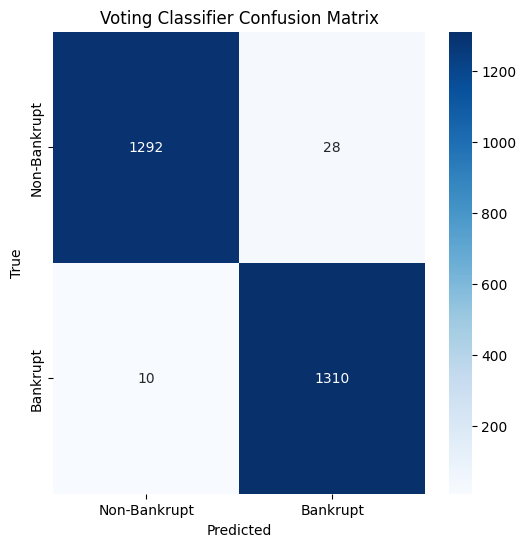

In [32]:
x = df.drop('Bankrupt?', axis=1) 
y = df['Bankrupt?']  

# Handle missing values (in case it's not done yet)
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x[x > 1e10] = np.nan
x[x < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
x_imputed = imputer.fit_transform(x)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_imputed, y)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='hard')  # 'hard' voting means majority class is predicted

# Create a pipeline that includes SMOTE, imputation, scaling, and the ensemble model
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Oversample the minority class
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(x_train, y_train)

# Make predictions with the trained pipeline
y_pred = pipeline.predict(x_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

This is such a good model. I'm very sus. Let's test it out. 

In [33]:
# Before applying SMOTE, check class distribution in the original data
print("Class distribution before SMOTE:")
print(y.value_counts())

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_imputed, y)

# After applying SMOTE, check class distribution in the resampled data
print("\nClass distribution after SMOTE:")
print(pd.Series(y_res).value_counts())

Class distribution before SMOTE:
Bankrupt?
0    6599
1     220
Name: count, dtype: int64

Class distribution after SMOTE:
Bankrupt?
1    6599
0    6599
Name: count, dtype: int64


Evaluating how the model works performance wise without SMOTE. Ie on real, non-synthetic data.

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.55      0.14      0.22        44

    accuracy                           0.97      1364
   macro avg       0.76      0.57      0.60      1364
weighted avg       0.96      0.97      0.96      1364


Confusion Matrix:
[[1315    5]
 [  38    6]]


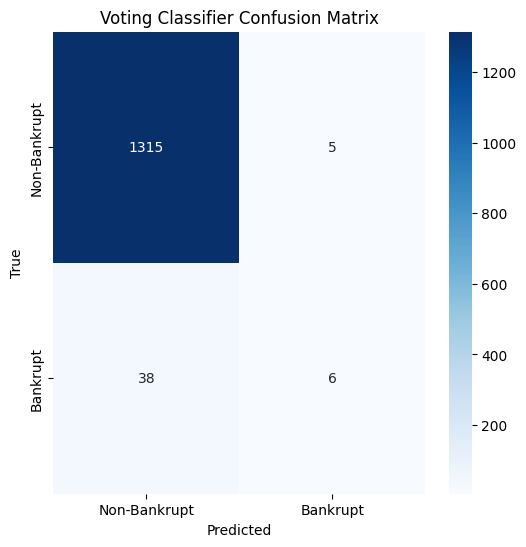

In [34]:
# Features and target
x = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values (in case it's not done yet)
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x[x > 1e10] = np.nan
x[x < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(x)

# Split the data into training and testing sets (without SMOTE)
x_train, x_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='hard')  # 'hard' voting means majority class is predicted

# Create a pipeline that includes imputation, scaling, and the ensemble model
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(x_train, y_train)

# Make predictions with the trained pipeline
y_pred = pipeline.predict(x_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally: Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Let's include an ROC-AUC score. 

ROC-AUC Score: 0.9987


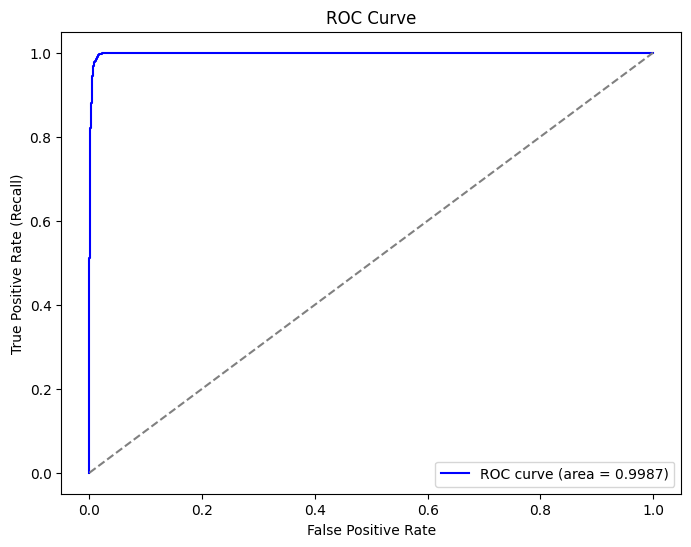

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1320
           1       0.98      1.00      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640


Confusion Matrix:
[[1287   33]
 [   1 1319]]


In [35]:
# Features and target
x = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values (in case it's not done yet)
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x[x > 1e10] = np.nan
x[x < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
x_imputed = imputer.fit_transform(x)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_imputed, y)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')  # 'hard' voting means majority class is predicted

# Create a pipeline that includes SMOTE, imputation, scaling, and the ensemble model
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Oversample the minority class
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(x_train, y_train)

# Make predictions with the trained pipeline
y_pred = pipeline.predict(x_test)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(x_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(x_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


check with validation data. 

Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1320
           1       0.97      1.00      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640


Validation Confusion Matrix:
[[1277   43]
 [   6 1314]]
Validation ROC-AUC Score: 0.9979


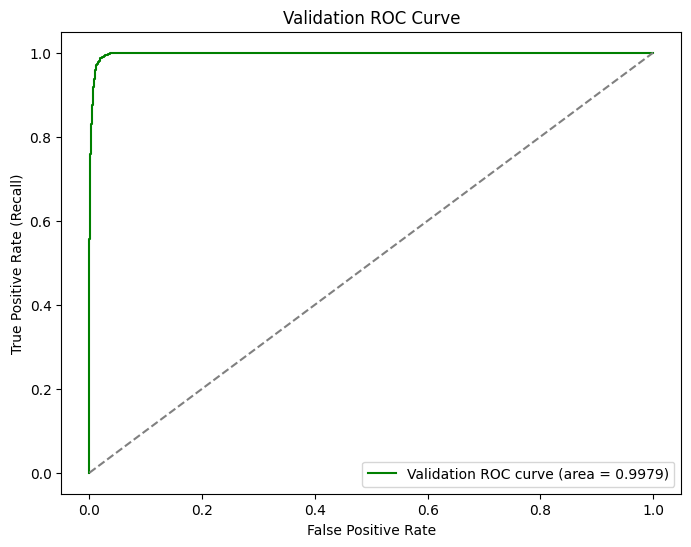

Test ROC-AUC Score: 0.9983


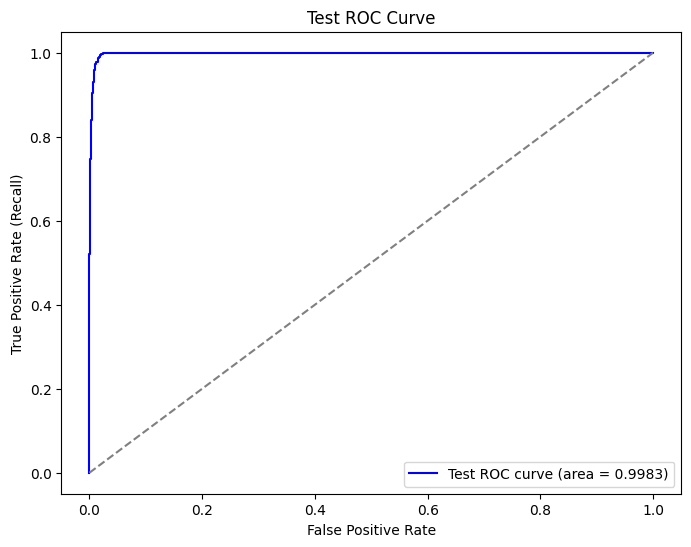

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1320
           1       0.97      1.00      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640


Test Confusion Matrix:
[[1281   39]
 [   2 1318]]


In [36]:
# Features and target
x = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values (in case it's not done yet)
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x[x > 1e10] = np.nan
x[x < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
x_imputed = imputer.fit_transform(x)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_imputed, y)

# Split the data into training, validation, and testing sets
x_temp, x_val, y_temp, y_val = train_test_split(
    x_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)  # Reserve 20% for validation

x_train, x_test, y_train, y_test = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 60% training, 20% testing (since 0.25 of 80% = 20%)

# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')  # 'soft' voting allows probabilities to be used

# Create a pipeline that includes SMOTE, scaling, and the ensemble model
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(x_train, y_train)

# Evaluate on the validation set
y_val_pred = pipeline.predict(x_val)
y_val_proba = pipeline.predict_proba(x_val)[:, 1]

# Calculate metrics for validation data
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Calculate ROC-AUC for validation data
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC Score: {roc_auc_val:.4f}")

# Plot ROC Curve for validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='g', label=f'Validation ROC curve (area = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Validation ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test set
y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

# Calculate ROC-AUC score for the test data
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='b', label=f'Test ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Test ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test set
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))